In [1]:
import chromadb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    f1_score,
    accuracy_score,
    make_scorer
)
from sklearn.preprocessing import LabelEncoder

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## Load Training Data

In [2]:
client = chromadb.PersistentClient(path="../chromadb")

# Get collections
train_collection = client.get_collection("airline_sentiment_train")
test_collection = client.get_collection("airline_sentiment_test")

print(f"Train collection: {train_collection.count()} documents")
print(f"Test collection: {test_collection.count()} documents")

# Retrieve all data
train_data = train_collection.get(include=["embeddings", "metadatas"])
test_data = test_collection.get(include=["embeddings", "metadatas"])

# Convert to arrays
X_train = np.array(train_data['embeddings'])
y_train = np.array([meta['label'] for meta in train_data['metadatas']])

X_test = np.array(test_data['embeddings'])
y_test = np.array([meta['label'] for meta in test_data['metadatas']])

print(f"\nX_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Class distribution (train): {np.unique(y_train, return_counts=True)}")

# Encode labels as integers for XGBoost
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

print(f"\nLabel encoding:")
print(f"  Classes: {le.classes_}")
print(f"  negative={le.transform(['negative'])[0]}, neutral={le.transform(['neutral'])[0]}, positive={le.transform(['positive'])[0]}")

Train collection: 11418 documents
Test collection: 2855 documents

X_train shape: (11418, 384)
X_test shape: (2855, 384)
Class distribution (train): (array(['negative', 'neutral', 'positive'], dtype='<U8'), array([7255, 2372, 1791]))

Label encoding:
  Classes: ['negative' 'neutral' 'positive']
  negative=0, neutral=1, positive=2


## Hyperparameter Tuning with RandomizedSearchCV

Using RandomizedSearchCV to find optimal hyperparameters with weighted F1-score as the optimization metric.

In [3]:
from sklearn.model_selection import StratifiedKFold


xgb = XGBClassifier(
    random_state=42,
    objective='multi:softprob',
    eval_metric='mlogloss',
    n_jobs=-1
)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


param_grid = {
    # 'n_estimators': [100, 150, 200],
    # 'max_depth': [5, 6, 7],
    # 'learning_rate': [0.08, 0.1, 0.12],
    # 'subsample': [0.7, 0.8, 0.9, 1.0],
    # 'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    # 'min_child_weight': [1, 3, 5],
    # 'gamma': [0, 0.5, 1, 5],
    # 'reg_alpha': [0, 0.1, 0.5],
    # 'reg_lambda': [1, 5, 10]
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8],  # Less deep
    'learning_rate': [0.05, 0.1, 0.15],  # Around the default
    'subsample': [0.8, 0.9, 1.0],

    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_weight': [1, 3],  # Less variation
    'gamma': [0, 0.1, 0.5],  # Less aggressive
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 2, 5]
}

f1_scorer = make_scorer(f1_score, average='weighted')

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=30, 
    scoring=f1_scorer,
    cv=skf,  # Use stratified folds
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Use sample weights
classes = np.unique(y_train_encoded)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train_encoded)
weight_dict = dict(zip(classes, class_weights))
sample_weights = np.array([weight_dict[y] for y in y_train_encoded])


random_search.fit(X_train, y_train_encoded, sample_weight=sample_weights)

print("\n" + "="*60)
print("HYPERPARAMETER TUNING RESULTS")
print("="*60)
print("Best parameters:", random_search.best_params_)
print(f"Best weighted F1 (CV): {random_search.best_score_:.4f}")
print("="*60)

Starting hyperparameter tuning...
Total parameter combinations to try: 30
Cross-validation folds: StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
Sample weights: [0.52460372 1.60455312 2.12506979]
Fitting 5 folds for each of 30 candidates, totalling 150 fits

HYPERPARAMETER TUNING RESULTS
Best parameters: {'subsample': 1.0, 'reg_lambda': 5, 'reg_alpha': 0.1, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 4, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.9}
Best weighted F1 (CV): 0.7605


## Evaluate Best Model on Test Set


BEST MODEL EVALUATION
Metric                         Train            Test
------------------------------------------------------------
F1-Score                      0.8870          0.7998
Accuracy                      0.8845          0.7937

Classification Report (Test Set):
              precision    recall  f1-score   support

    negative       0.92      0.83      0.87      1814
     neutral       0.58      0.70      0.64       593
    positive       0.69      0.75      0.72       448

    accuracy                           0.79      2855
   macro avg       0.73      0.76      0.74      2855
weighted avg       0.81      0.79      0.80      2855



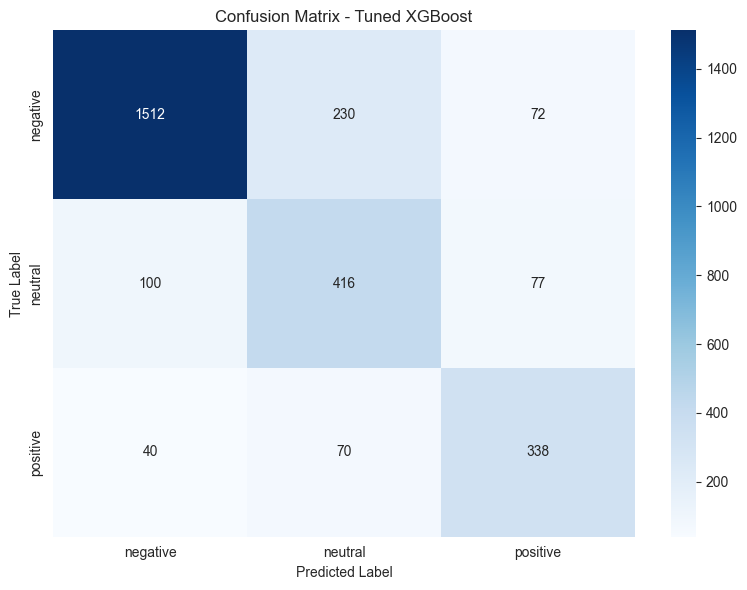

In [4]:
# Get best model
best_xgb_model = random_search.best_estimator_

# Predictions on training set
y_train_pred_encoded = best_xgb_model.predict(X_train)
y_train_pred = le.inverse_transform(y_train_pred_encoded)

# Predictions on test set
y_test_pred_encoded = best_xgb_model.predict(X_test)
y_test_pred = le.inverse_transform(y_test_pred_encoded)

# Calculate metrics
train_f1 = f1_score(y_train, y_train_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print("\n" + "="*60)
print("BEST MODEL EVALUATION")
print("="*60)
print(f"{'Metric':<20} {'Train':>15} {'Test':>15}")
print("-"*60)
print(f"{'F1-Score':<20} {train_f1:>15.4f} {test_f1:>15.4f}")
print(f"{'Accuracy':<20} {train_acc:>15.4f} {test_acc:>15.4f}")
print("="*60)

# Classification Report
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred, labels=['negative', 'neutral', 'positive'])
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['negative', 'neutral', 'positive'], 
            yticklabels=['negative', 'neutral', 'positive'])
plt.title('Confusion Matrix - Tuned XGBoost')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

## Top Parameter Combinations

Analyzing the best parameter combinations from the search.


TOP 10 PARAMETER COMBINATIONS
    mean_test_score  std_test_score  rank_test_score  param_subsample  param_reg_lambda  param_reg_alpha  param_n_estimators  param_min_child_weight  param_max_depth  param_learning_rate  param_gamma  param_colsample_bytree
28         0.760507        0.007711                1              1.0                 5              0.1                 200                       3                4                 0.05          0.0                     0.9
23         0.757060        0.005108                2              0.9                 1              0.0                 200                       3                4                 0.05          0.5                     1.0
10         0.756692        0.009025                3              1.0                 1              0.1                 100                       3                4                 0.15          0.1                     0.8
8          0.756506        0.007100                4              0.9    

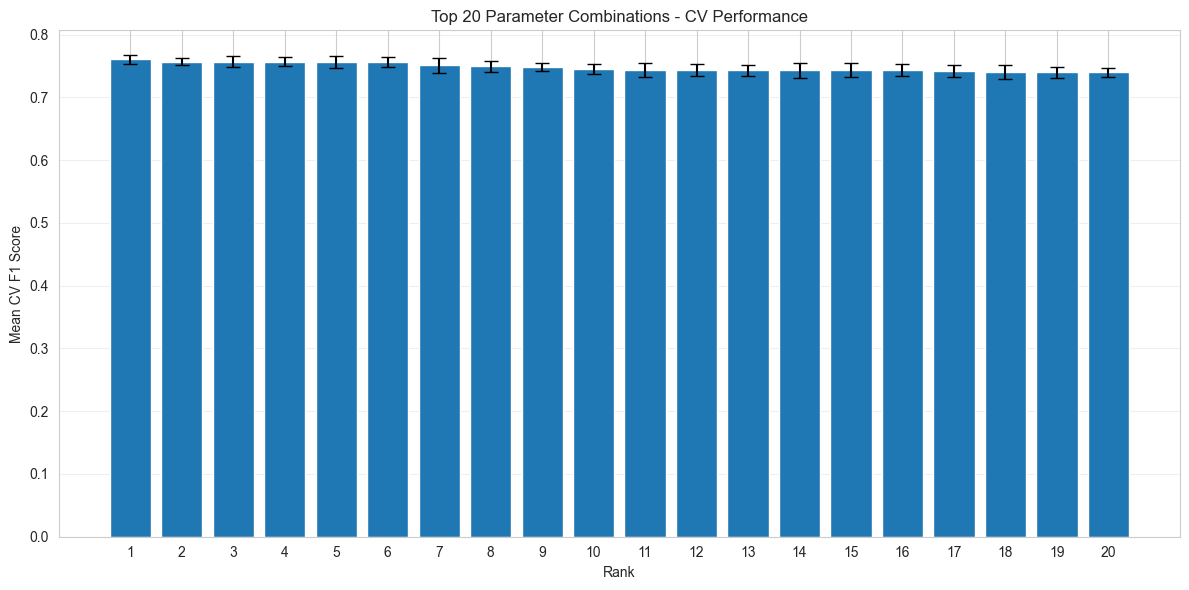

In [5]:
# Get results
results_df = pd.DataFrame(random_search.cv_results_)

# Select relevant columns
cols_to_show = ['mean_test_score', 'std_test_score', 'rank_test_score'] + \
               [col for col in results_df.columns if col.startswith('param_')]

results_subset = results_df[cols_to_show].sort_values('rank_test_score')

# Show top 10 results
print("\n" + "="*80)
print("TOP 10 PARAMETER COMBINATIONS")
print("="*80)
print(results_subset.head(10).to_string())
print("="*80)

# Plot top 20 scores
plt.figure(figsize=(12, 6))
top_20 = results_subset.head(20)
plt.bar(range(len(top_20)), top_20['mean_test_score'], 
        yerr=top_20['std_test_score'], capsize=5)
plt.xlabel('Rank')
plt.ylabel('Mean CV F1 Score')
plt.title('Top 20 Parameter Combinations - CV Performance')
plt.xticks(range(len(top_20)), range(1, len(top_20)+1))
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Save Best Model

In [6]:
os.makedirs("../models", exist_ok=True)

# Save tuned model
with open("../models/xgb_tuned_model.pkl", "wb") as f:
    pickle.dump(best_xgb_model, f)

# Save label encoder
with open("../models/label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

# Save best parameters
with open("../models/xgb_best_params.pkl", "wb") as f:
    pickle.dump(random_search.best_params_, f)

print("✅ Tuned XGBoost model saved to ../models/xgb_tuned_model.pkl")
print("✅ Label encoder saved to ../models/label_encoder.pkl")
print("✅ Best parameters saved to ../models/xgb_best_params.pkl")
print(f"\nTest F1-Score: {test_f1:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

✅ Tuned XGBoost model saved to ../models/xgb_tuned_model.pkl
✅ Label encoder saved to ../models/label_encoder.pkl
✅ Best parameters saved to ../models/xgb_best_params.pkl

Test F1-Score: 0.7998
Test Accuracy: 0.7937
